# Сегментация лесных массивов с помощью U-Net

## 1. Импорт библиотек и настройка окружения

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Проверка доступности CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


### 1.1 Подготовка данных 

In [2]:
# Пути к данным
train_images_dir = '/home/s2pac/ElbrusBootcamp/Nikitaproject/prodject/train/images'
train_masks_dir = '/home/s2pac/ElbrusBootcamp/Nikitaproject/prodject/train/masks'
val_images_dir = '/home/s2pac/ElbrusBootcamp/Nikitaproject/prodject/val/images'
val_masks_dir = '/home/s2pac/ElbrusBootcamp/Nikitaproject/prodject/val/masks'


In [3]:
# Проверяем, что пути к данным существуют и содержат файлы
import os

print("Проверка тренировочных изображений:", os.path.exists(train_images_dir), "Количество файлов:", len(os.listdir(train_images_dir)))
print("Проверка тренировочных масок:", os.path.exists(train_masks_dir), "Количество файлов:", len(os.listdir(train_masks_dir)))
print("Проверка валидационных изображений:", os.path.exists(val_images_dir), "Количество файлов:", len(os.listdir(val_images_dir)))
print("Проверка валидационных масок:", os.path.exists(val_masks_dir), "Количество файлов:", len(os.listdir(val_masks_dir)))



Проверка тренировочных изображений: True Количество файлов: 4086
Проверка тренировочных масок: True Количество файлов: 4086
Проверка валидационных изображений: True Количество файлов: 1022
Проверка валидационных масок: True Количество файлов: 1022


## 2. Архитектура U-Net

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder
        x = self.up1(x5)
        x = self.up_conv1(torch.cat([x4, x], dim=1))
        x = self.up2(x)
        x = self.up_conv2(torch.cat([x3, x], dim=1))
        x = self.up3(x)
        x = self.up_conv3(torch.cat([x2, x], dim=1))
        x = self.up4(x)
        x = self.up_conv4(torch.cat([x1, x], dim=1))

        return torch.sigmoid(self.outc(x))

## 3. Датасет и аугментации

In [5]:
class ForestDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        
        # Правильное формирование имени файла маски
        # Из '10452_sat_08.jpg' делаем '10452_mask_08.jpg'
        mask_name = self.images[index].replace('_sat_', '_mask_')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        # Проверяем, что файлы существуют
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Изображение не найдено: {img_path}")
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Маска не найдена: {mask_path}")
        
        try:
            image = np.array(Image.open(img_path).convert('RGB'))
            mask = np.array(Image.open(mask_path).convert('L'))
            mask = mask.astype(np.float32) / 255.0
        except Exception as e:
            raise RuntimeError(f"Ошибка при загрузке изображения {img_path} или маски {mask_path}: {e}")
        
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask

# Аугментации для тренировки
train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=1, p=0.5),
    ], p=0.3),
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
    ], p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Аугментации для валидации
val_transform = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])


/home/s2pac/miniforge3/envs/yolo/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
# Создаем датасеты
train_dataset = ForestDataset(train_images_dir, train_masks_dir, transform=train_transform)
val_dataset = ForestDataset(val_images_dir, val_masks_dir, transform=val_transform)

In [7]:
# Тестирование загрузки данных
print("Тестирование загрузки данных...")
try:
    test_dataset = ForestDataset(train_images_dir, train_masks_dir, transform=None)
    print(f"Размер датасета: {len(test_dataset)}")
    
    # Тестируем загрузку одного элемента
    image, mask = test_dataset[0]
    print(f"Размер изображения: {image.shape}")
    print(f"Размер маски: {mask.shape}")
    print(f"Тип данных изображения: {image.dtype}")
    print(f"Тип данных маски: {mask.dtype}")
    print(f"Диапазон значений маски: [{mask.min():.3f}, {mask.max():.3f}]")
    print("Тест загрузки данных прошел успешно!")
except Exception as e:
    print(f"Ошибка при тестировании: {e}")


Тестирование загрузки данных...
Размер датасета: 4086
Размер изображения: (256, 256, 3)
Размер маски: (256, 256)
Тип данных изображения: uint8
Тип данных маски: float32
Диапазон значений маски: [0.000, 1.000]
Тест загрузки данных прошел успешно!


In [8]:
# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Training samples: 4086
Validation samples: 1022


## 4. Метрики

In [9]:
def dice_coefficient(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1.0):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_metrics(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    dice = dice_coefficient(pred, target)
    iou = iou_score(pred, target)
    return dice, iou

## 5. Обучение модели

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks in tqdm(loader, desc='Training'):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc='Validation'):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).unsqueeze(1)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    
    return total_loss / len(loader)

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_metrics = []
    val_metrics = []
    
    # Инициализация scheduler и early stopping
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    early_stopping = EarlyStopping(patience=7, min_delta=0.001)
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Обучение
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Валидация
        val_loss = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        # Расчет метрик
        model.eval()
        train_dice, train_iou = 0, 0
        val_dice, val_iou = 0, 0
        
        with torch.no_grad():
            for images, masks in train_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                dice, iou = calculate_metrics(outputs, masks)
                train_dice += dice.item()
                train_iou += iou.item()
            
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                dice, iou = calculate_metrics(outputs, masks)
                val_dice += dice.item()
                val_iou += iou.item()
        
        train_dice /= len(train_loader)
        train_iou /= len(train_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        
        train_metrics.append((train_dice, train_iou))
        val_metrics.append((val_dice, val_iou))
        
        print(f'Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Train IoU: {train_iou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}, Val IoU: {val_iou:.4f}')
        
        # Обновление learning rate
        scheduler.step(val_loss)
        
        # Сохранение лучшей модели
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print('Saved best model!')
        
        # Проверка early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print('Early stopping triggered')
            break
    
    return train_losses, val_losses, train_metrics, val_metrics

In [12]:
def plot_metrics(train_losses, val_losses, train_metrics, val_metrics):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Dice scores
    plt.subplot(1, 3, 2)
    train_dice = [m[0] for m in train_metrics]
    val_dice = [m[0] for m in val_metrics]
    plt.plot(train_dice, label='Train Dice')
    plt.plot(val_dice, label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    
    # Plot IoU scores
    plt.subplot(1, 3, 3)
    train_iou = [m[1] for m in train_metrics]
    val_iou = [m[1] for m in val_metrics]
    plt.plot(train_iou, label='Train IoU')
    plt.plot(val_iou, label='Val IoU')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1/10


Validation: 100%|██████████| 128/128 [00:12<00:00, 10.09it/s]


Train Loss: 0.5302, Train Dice: 0.8104, Train IoU: 0.6879
Val Loss: 0.4841, Val Dice: 0.8227, Val IoU: 0.7048
Saved best model!

Epoch 2/10


Validation: 100%|██████████| 128/128 [00:12<00:00, 10.10it/s]


Train Loss: 0.4966, Train Dice: 0.8139, Train IoU: 0.6937
Val Loss: 0.4644, Val Dice: 0.8344, Val IoU: 0.7215
Saved best model!

Epoch 3/10


Validation: 100%|██████████| 128/128 [00:12<00:00, 10.11it/s]


Train Loss: 0.4800, Train Dice: 0.8188, Train IoU: 0.7005
Val Loss: 0.4583, Val Dice: 0.8336, Val IoU: 0.7206
Saved best model!

Epoch 4/10


Validation: 100%|██████████| 128/128 [00:12<00:00, 10.07it/s]


Train Loss: 0.4599, Train Dice: 0.8164, Train IoU: 0.6974
Val Loss: 0.4544, Val Dice: 0.8320, Val IoU: 0.7185
Saved best model!

Epoch 5/10


Validation: 100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Train Loss: 0.4569, Train Dice: 0.8204, Train IoU: 0.7032
Val Loss: 0.4507, Val Dice: 0.8365, Val IoU: 0.7241
Saved best model!

Epoch 6/10


Validation: 100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Train Loss: 0.4552, Train Dice: 0.8286, Train IoU: 0.7144
Val Loss: 0.4423, Val Dice: 0.8358, Val IoU: 0.7240
Saved best model!

Epoch 7/10


Validation: 100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Train Loss: 0.4463, Train Dice: 0.8222, Train IoU: 0.7053
Val Loss: 0.4408, Val Dice: 0.8359, Val IoU: 0.7239
Saved best model!

Epoch 8/10


Validation: 100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Train Loss: 0.4441, Train Dice: 0.8356, Train IoU: 0.7244
Val Loss: 0.4520, Val Dice: 0.8427, Val IoU: 0.7338

Epoch 9/10


Validation: 100%|██████████| 128/128 [00:11<00:00, 10.79it/s]


Train Loss: 0.4426, Train Dice: 0.8348, Train IoU: 0.7231
Val Loss: 0.4319, Val Dice: 0.8466, Val IoU: 0.7392
Saved best model!

Epoch 10/10


Validation: 100%|██████████| 128/128 [00:11<00:00, 10.80it/s]


Train Loss: 0.4345, Train Dice: 0.8394, Train IoU: 0.7291
Val Loss: 0.4264, Val Dice: 0.8440, Val IoU: 0.7361
Saved best model!


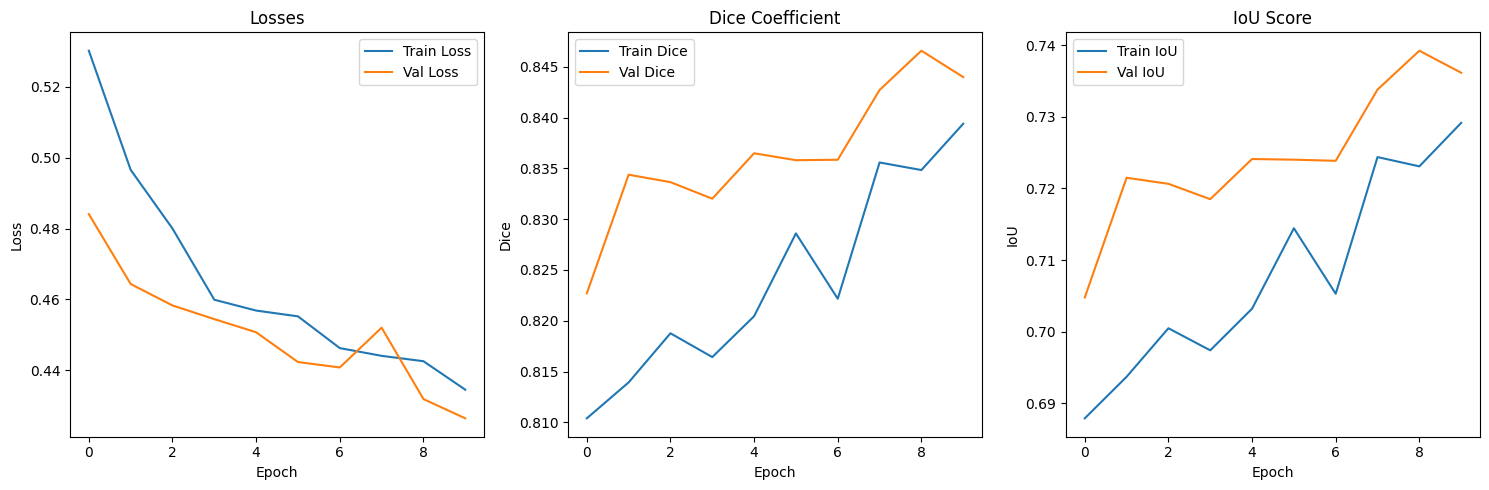

In [13]:
# Инициализация модели и оптимизатора
model = UNet(n_channels=3, n_classes=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Обучение модели
train_losses, val_losses, train_metrics, val_metrics = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)

# Визуализация метрик
plot_metrics(train_losses, val_losses, train_metrics, val_metrics)

## 6. Инференс и визуализация результатов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.378562].


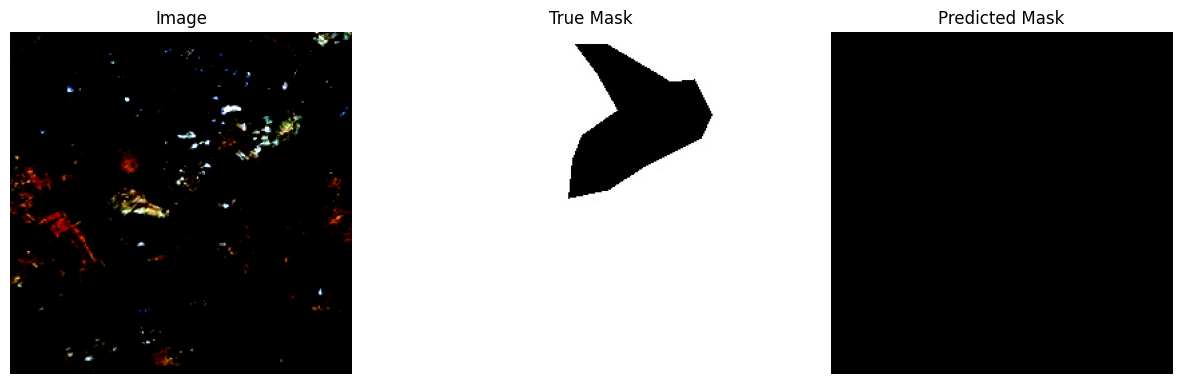

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5356623..2.2489083].


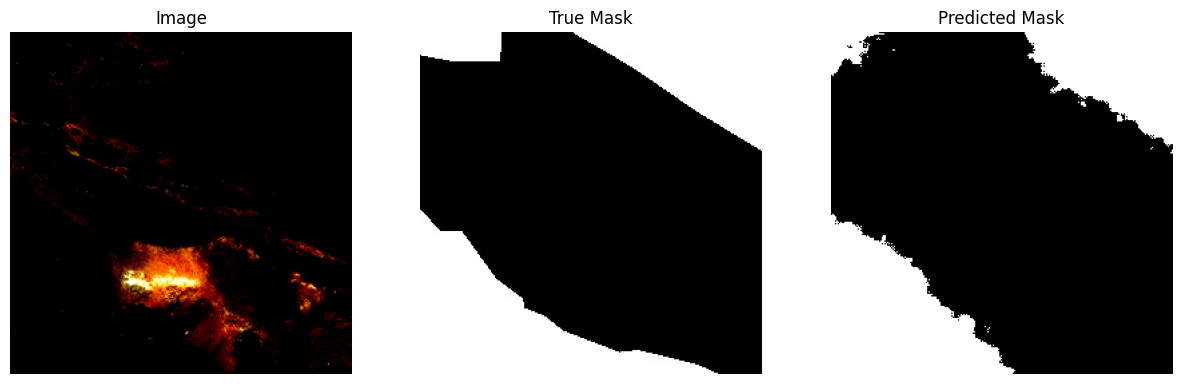

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.68244..2.4285712].


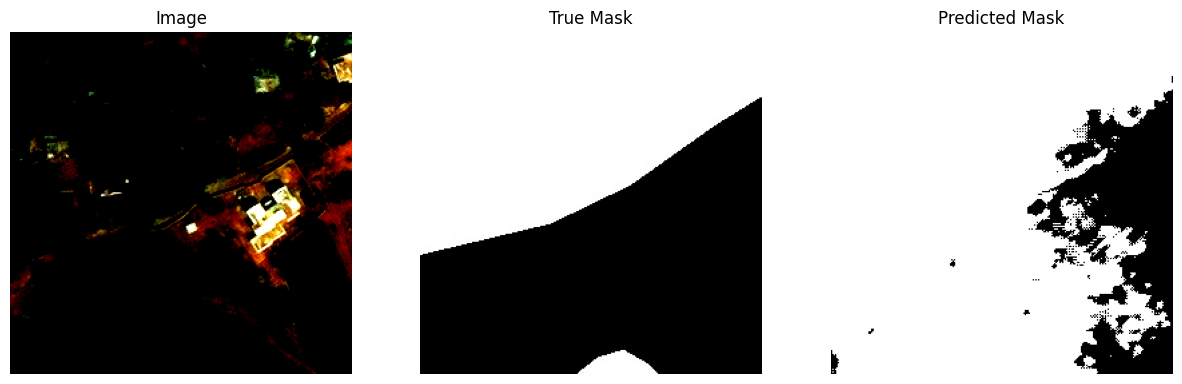

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0190849].


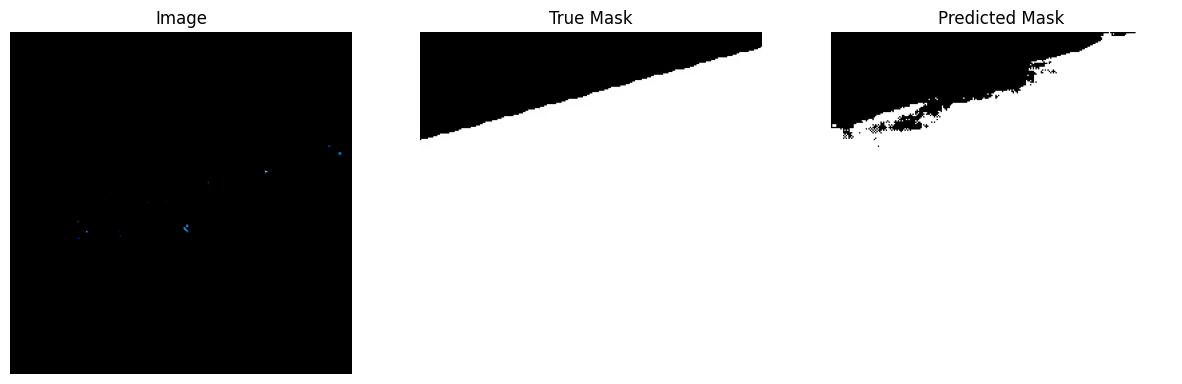

In [15]:
# Загрузка лучшей модели и визуализация результатов
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        
        # Показываем первые 4 изображения из батча
        for i in range(4):
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            plt.title('Image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(masks[i].cpu().numpy(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(preds[i].squeeze(0).cpu().numpy(), cmap='gray')  # Исправлено: добавлен squeeze(0)
            plt.title('Predicted Mask')
            plt.axis('off')
            plt.show()
        break

In [16]:
torch.save(model.state_dict(), 'forest_segmentation_model.pth')

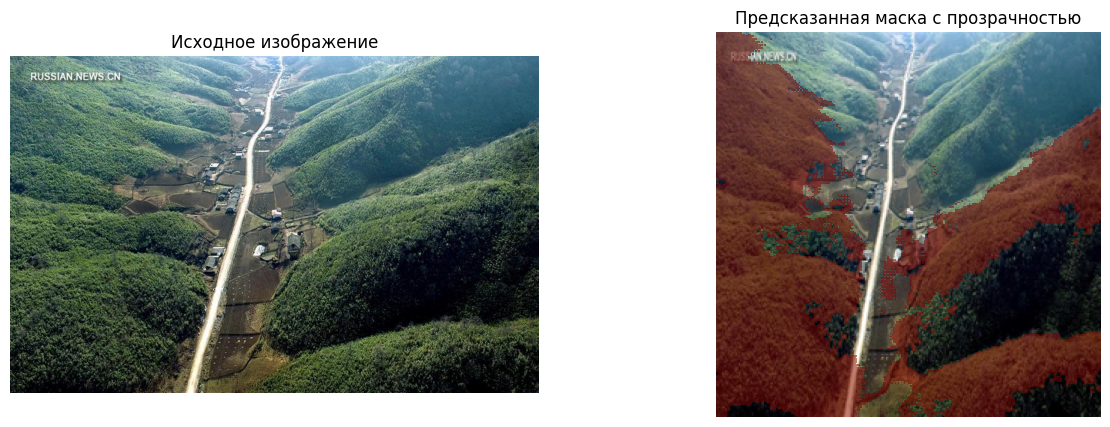

In [28]:
# Загрузка и обработка тестового изображения из интернета
from PIL import Image
import requests
from io import BytesIO
import numpy as np
import torchvision.transforms as transforms

# URL изображения для теста
image_url = 'https://russian.news.cn/photo/2016-12/06/135883913_14809906178831n.jpg'  # Замените на реальный URL

# Скачиваем изображение
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')

# Преобразования для изображения (должны соответствовать тем, что использовались при обучении)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Применяем преобразования
input_tensor = transform(img).unsqueeze(0).to(device)  # Добавляем batch dimension

# Делаем предсказание
with torch.no_grad():
    output = model(input_tensor)
    pred = (output > 0.5).float()

# Визуализация результатов с прозрачностью маски
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Исходное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
# Создаем изображение с прозрачностью
pred_np = pred.squeeze().cpu().numpy()
# Нормализуем маску к диапазону 0-1 для альфа-канала
alpha_mask = np.where(pred_np > 0.5, 0.5, 0.0)  # 0.5 - уровень прозрачности для маски
# Наложение маски на оригинальное изображение
plt.imshow(img.resize((256, 256)))  # Приводим к размеру маски
plt.imshow(pred_np, cmap='jet', alpha=alpha_mask, interpolation='nearest')
plt.title('Предсказанная маска с прозрачностью')
plt.axis('off')
plt.show()
